# Part 1

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

# Create features and labels
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf

# to define loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

### Load the 'Part 1- Train data - images.npy' file.

In [ ]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle = True, **k)

data = np.load('Part 1- Train data - images.npy')

### Check one sample from the loaded file.

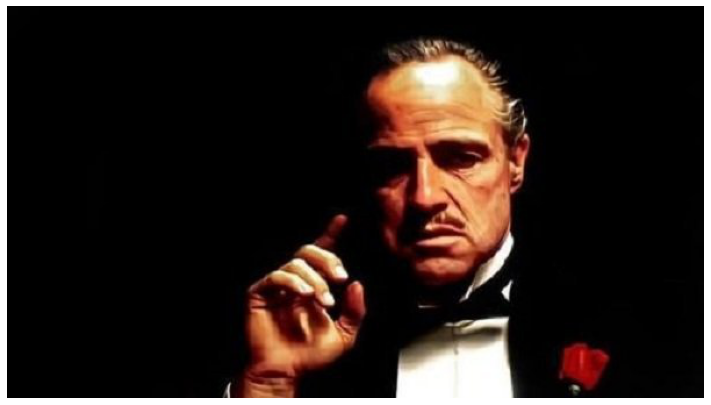

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[10][0])
plt.show()

### Set image dimensions.

In [ ]:
ALPHA = 1
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Create features and labels.

- Here feature is the image.
- The label is the mask.
- Images will be stored in 'X' array.
- Masks will be stored in 'masks' array.

In [ ]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
        img = img[:, :, :3]
    except:
        continue
    X[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array.

In [ ]:
X.shape

(409, 224, 224, 3)

In [ ]:
masks.shape

(409, 224, 224)

### Print a sample image and image array.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


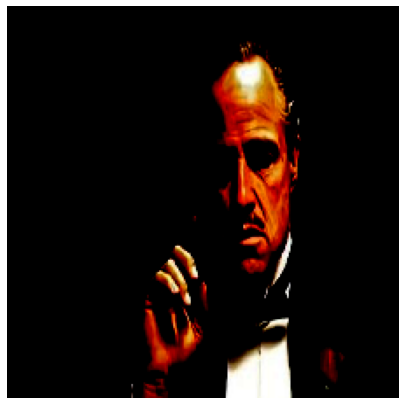

In [ ]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

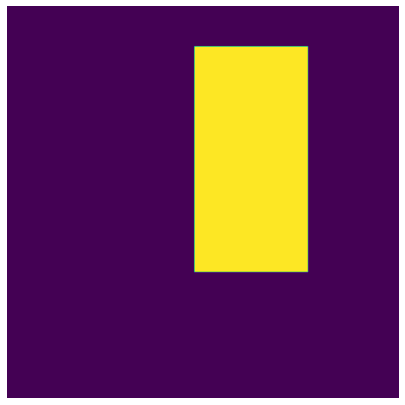

In [ ]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(masks[n])

### Create the model.

- Add MobileNet as model with below parameter values:
    - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
    - include_top: False
    - alpha: 1.0
    - weights: 'imagenet'
- Add UNET architecture layers.

In [ ]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)

### Call the create_model function.

In [ ]:
model = create_model(True)
model.summary()

17227776/17225924 [==============================] - 8s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________

### Define dice coefficient function.

In [ ]:
# Create a function to calculate dice coefficient.

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss.

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model.

- Complie the model using below parameters:
    - loss: use the loss function defined above.
    - optimizers: use Adam optimizer.
    - metrics: use dice_coefficient function defined above.

In [ ]:
adam = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

### Define checkpoint and earlystopping.

In [ ]:
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', period = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

### Fit the model.

- Fit the model using below parameters:
    - epochs: you can decide.
    - batch_size: 1
    - callbacks: checkpoint, reduce_lr, stop

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, masks, test_size = 0.15, random_state = 2019, shuffle = False)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((347, 224, 224, 3), (62, 224, 224, 3), (347, 224, 224), (62, 224, 224))

In [ ]:
model.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_valid, y_valid))

Epoch 1/30
347/347 [==============================] - ETA: 0s - loss: 1.6227 - dice_coefficient: 0.3701
Epoch 00001: loss improved from inf to 1.62272, saving model to model_1.62.h5
347/347 [==============================] - 309s 891ms/step - loss: 1.6227 - dice_coefficient: 0.3701 - val_loss: 1.4861 - val_dice_coefficient: 0.4092
Epoch 2/30
347/347 [==============================] - ETA: 0s - loss: 1.1638 - dice_coefficient: 0.4719
Epoch 00002: loss improved from 1.62272 to 1.16376, saving model to model_1.16.h5
347/347 [==============================] - 386s 1s/step - loss: 1.1638 - dice_coefficient: 0.4719 - val_loss: 1.1222 - val_dice_coefficient: 0.4674
Epoch 3/30
347/347 [==============================] - ETA: 0s - loss: 0.9418 - dice_coefficient: 0.5416
Epoch 00003: loss improved from 1.16376 to 0.94180, saving model to model_0.94.h5
347/347 [==============================] - 303s 872ms/step - loss: 0.9418 - dice_coefficient: 0.5416 - val_loss: 0.9924 - val_dice_coefficient: 0.5

Epoch 26/30
347/347 [==============================] - ETA: 0s - loss: 0.1312 - dice_coefficient: 0.9400
Epoch 00026: loss did not improve from 0.12199
347/347 [==============================] - 296s 852ms/step - loss: 0.1312 - dice_coefficient: 0.9400 - val_loss: 1.0402 - val_dice_coefficient: 0.6072
Epoch 27/30
347/347 [==============================] - ETA: 0s - loss: 0.1334 - dice_coefficient: 0.9402
Epoch 00027: loss did not improve from 0.12199
347/347 [==============================] - 300s 864ms/step - loss: 0.1334 - dice_coefficient: 0.9402 - val_loss: 1.2609 - val_dice_coefficient: 0.5495
Epoch 28/30
347/347 [==============================] - ETA: 0s - loss: 0.1338 - dice_coefficient: 0.9412
Epoch 00028: loss did not improve from 0.12199
347/347 [==============================] - 294s 848ms/step - loss: 0.1338 - dice_coefficient: 0.9412 - val_loss: 1.4647 - val_dice_coefficient: 0.5334
Epoch 29/30
347/347 [==============================] - ETA: 0s - loss: 0.1183 - dice_coeffi

In [ ]:
model.evaluate(X_valid, y_valid, verbose = 1)

2/2 [==============================] - 3s 1s/step - loss: 0.9110 - dice_coefficient: 0.6244


[0.9110312461853027, 0.6243601441383362]

### Get the predicted mask for the given image.

In [ ]:
# Load previous model weight
WEIGHTS_FILE = "model_0.11.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)

In [ ]:
import PIL
from PIL import Image

In [ ]:
# Loading the given JPEG image to numpy array.
pred_img= Image.open("Part 1Test Data - Prediction Image.jpeg")
np_pred_img = np.array(pred_img)
  
print(np_pred_img.shape)

(500, 500, 3)


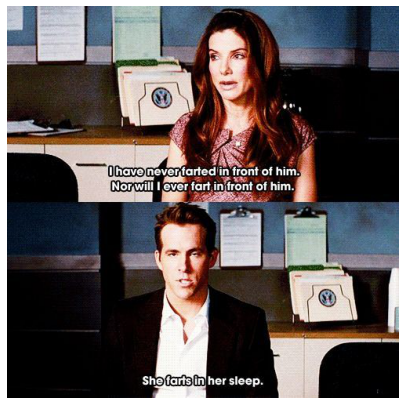

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(np_pred_img)
plt.show()

In [ ]:
A = np.zeros((int(1), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
img = np_pred_img
img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)

A[0] = preprocess_input(np.array(img, dtype = np.float32))

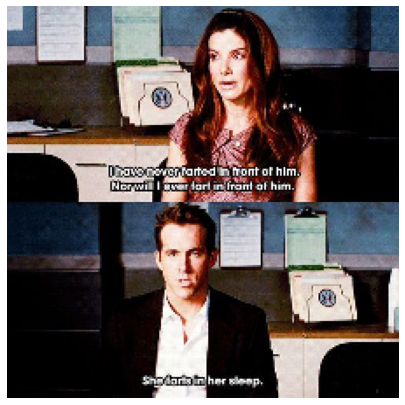

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(img)
plt.show()

In [ ]:
y_pred = learned_model.predict(A, verbose = 1)

1/1 [==============================] - 0s 2ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


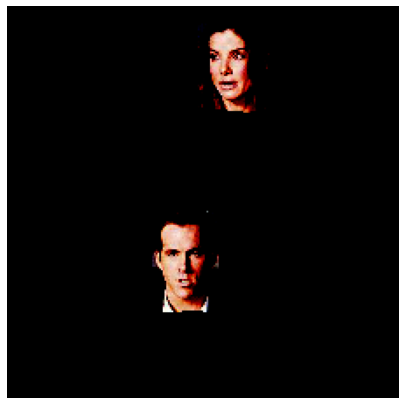

In [ ]:
# For this image predicted, the mask is.
n = 0
image = cv2.resize(A[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

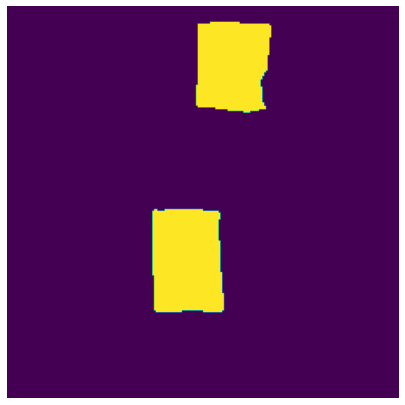

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

### Impose the mask on the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


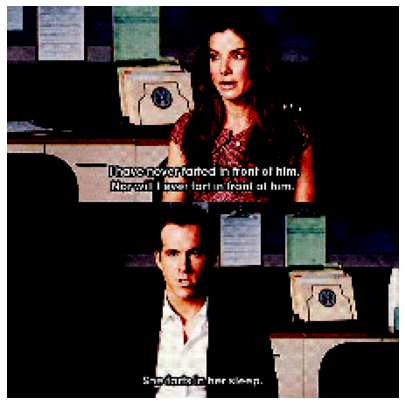

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(A[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

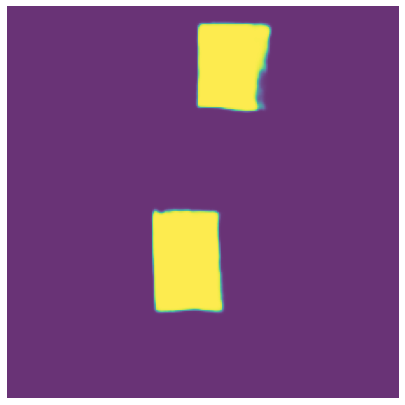

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

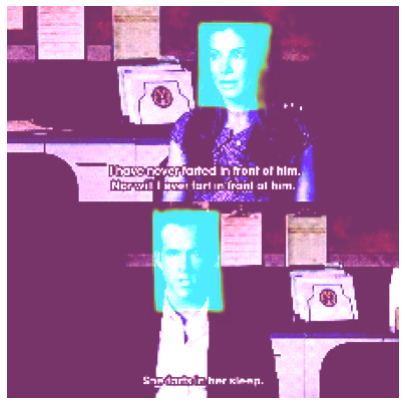

In [ ]:
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(img, alpha = 1)

# Part 2

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting the current working directory
import os; os.chdir('drive/My Drive/CNN')

In [ ]:
%tensorflow_version 2.x

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 2020

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 1.3.5
Numpy version: 1.21.6
Scikit-learn version: 1.0.2
Tensorflow version: 2.8.2
CV version: 4.1.2


### Extract the zip file.

- Extract Aligned Face Dataset from Pinterest.zip

In [ ]:
!ls

'Aligned Face Dataset from Pinterest.zip'
'Part 2- Test Image - Benedict Cumberbatch9.jpg'
'Part 2 - Test Image - Dwayne Johnson4.jpg'
'Part 2 - vgg_face_weights.h5'


In [ ]:
with ZipFile('Aligned Face Dataset from Pinterest.zip', 'r') as zip:
  zip.extractall()

### Function to load images.
- Define a function to load the images from the extracted folder and map each image with person id.

In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

### Define function to load image.
- Define a function to load image from the metadata.

In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

### Load a sample image.
- Load one image using the function "load_image".

In [ ]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

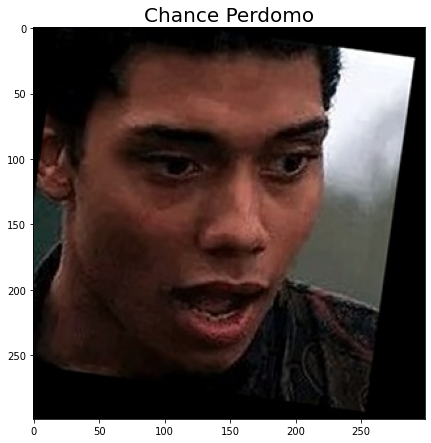

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

### VGG Face model.

In [ ]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

### Load the model.
- Load the model defined above.
- Then load the given weight file named "vgg_face_weights.h5"

In [ ]:
model = vgg_face()
model.load_weights('Part 2 - vgg_face_weights.h5')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_13 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                      

### Get vgg_face_descriptor.

In [ ]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

### Generate embeddings for each image in the dataset.
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model.

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images
- Write code to iterate through metadata and create embeddings for each image using vgg_face_descriptor.predict() and store in a list with name embeddings.

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [18]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

### Function to calculate distance between given 2 pairs of images.
- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [19]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

### Plot images and get distance between the pairs given below:

- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

In [20]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

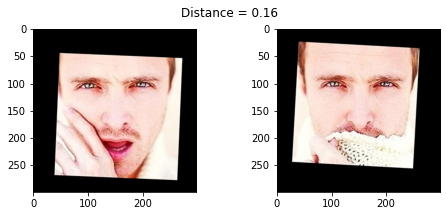

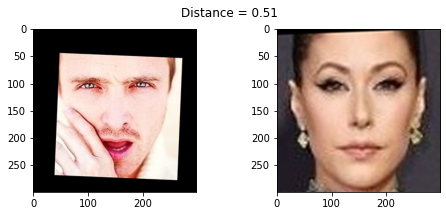

In [21]:
show_pair(2, 3)
show_pair(2, 180)

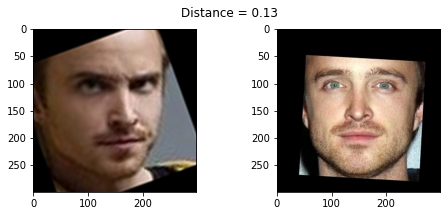

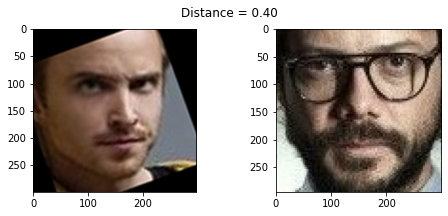

In [22]:
show_pair(30, 31)
show_pair(30, 100)

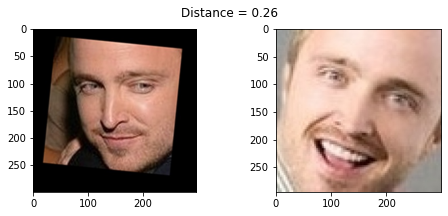

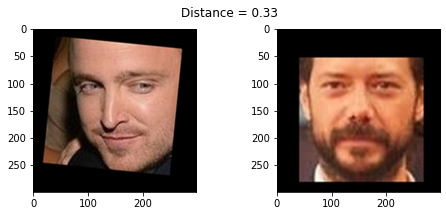

In [23]:
show_pair(70, 72)
show_pair(70, 115)

### Create train and test sets.

- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels.
- Use test_idx to seperate out testing features and labels.

In [24]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

### Encode the Labels.
- Encode the labels
- Use LabelEncoder

In [25]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

### Standardize the feature values.
- Scale the features using StandardScaler.

In [26]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Reduce dimensions using PCA.
- Reduce feature dimensions using Principal Component Analysis.

In [27]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.58890702  18.98690257  22.97728226 ...  99.99999983  99.99999999
 100.        ]


In [28]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 347


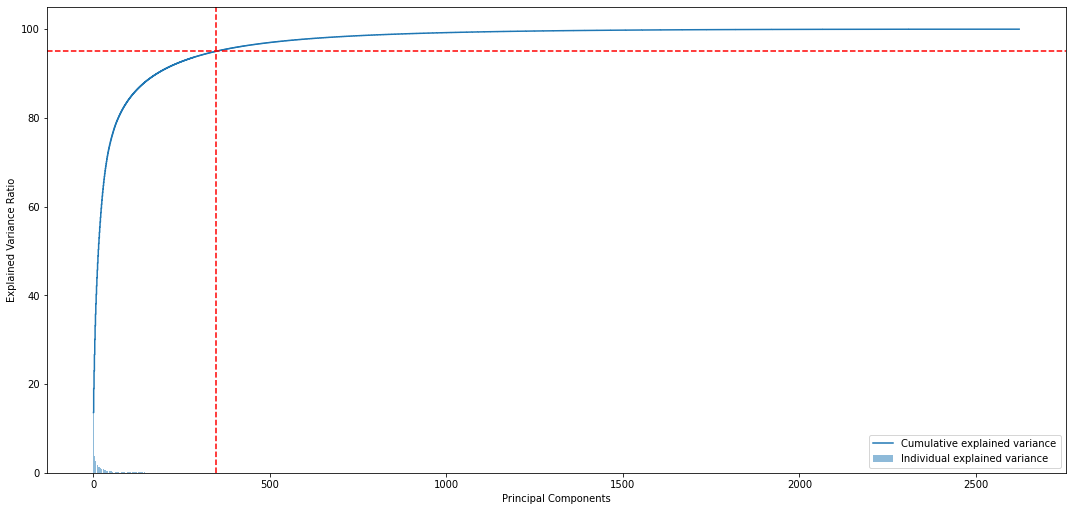

In [29]:
# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [30]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 347)

(1197, 347)

### Build a Classifier.
- Use SVM Classifier to predict the person in the given image.
- Fit the classifier and print the score.

In [ ]:
# params_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': ['balanced', None]}]

# svc = GridSearchCV(SVC(random_state = random_state), params_grid, cv = 3, scoring = 'f1_macro', verbose = 50, n_jobs = -1)
# svc.fit(X_train_pca, y_train)

# print('Best estimator found by grid search:')
# print(svc.best_estimator_)

# Best estimator found by grid search:
# SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced')

In [31]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.995


In [32]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.965


In [33]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        13
Alycia Debnam Carey Face       1.00      0.92      0.96        13
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      1.00      1.00         9
        Amber Heard Face       1.00      1.00      1.00         8
               Anna Gunn       0.88      1.00      0.93        14
           Anne Hathaway       0.93      0.93      0.93        14
     Barbara Palvin Face       1.00      0.89      0.94         9
      Bellamy Blake Face       0.93      1.00      0.96        13
    Benedict Cumberbatch       0.93      1.00      0.96        13
            Betsy Brandt       1.00      1.00      1.00         9
              Bill Gates       0.91      1.00      

### TEST Image Results.

In [34]:
def sample_img_plot(path):
  # Load image for sample_idx from test data
  sample_img = load_image(path)
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, pred_name

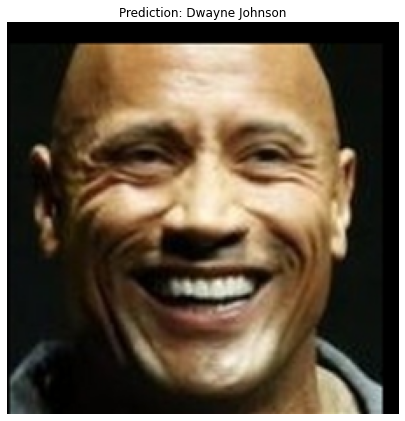

In [37]:
# Plot for Dwayne Johnson's image from the given test data.
sample_img, pred_name = sample_img_plot('Part 2 - Test Image - Dwayne Johnson4.jpg')
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"Prediction: {pred_name}")
plt.show()

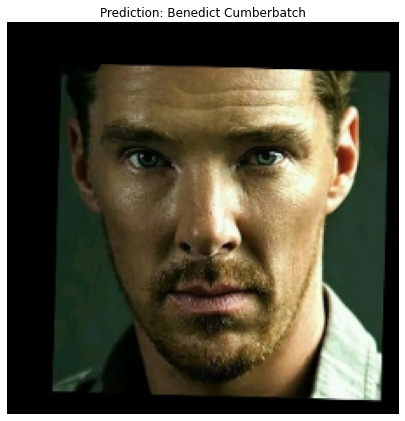

In [38]:
# Plot for Benedict Cumberbatch's image from the given test data.
sample_img, pred_name = sample_img_plot('Part 2- Test Image - Benedict Cumberbatch9.jpg')
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"Prediction: {pred_name}")
plt.show()